## Clinical-Trial Survival Analysis for Treatment Efficiency

## Theoretical Description
This project focuses on survival analysis in clinical trials to evaluate treatment effectiveness by analyzing time-to-event data, such as time until death. It applies statistical methods like Kaplan–Meier survival curves to visualize survival probabilities over time and uses the Log-Rank Test to compare different treatment groups. The  Cox Proportional Hazards Model  and its extensions, including time-varying covariates, stratified models, and competing risks models, are employed to explore more complex real-world scenarios where patient conditions change over time, risk patterns vary among individuals, and multiple outcomes are possible. This comprehensive analysis helps determine whether one treatment outperforms another and provides deeper insights into patient survival under different clinical interventions.


lifelines Python package is a library used for survival analysis.

In [ ]:
!pip install lifelines --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 3.9 MB/s eta 0:00:00




---

lifelines package: KaplanMeierFitter for non-parametric survival curves, CoxPHFitter for regression analysis on survival data, and logrank_test to statistically compare survival functions.

---



In [ ]:
from lifelines import KaplanMeierFitter,CoxPHFitter
from lifelines.statistics import logrank_test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/veteran.csv')
df

,ID,TIME,Y,trt,celltype,karno,diagtime,age,priortherapy
0,1,0,0,standard,squamous,60,7,69,no
1,1,72,1,standard,squamous,60,7,69,no
2,2,0,0,standard,squamous,70,5,64,yes
3,2,411,1,standard,squamous,70,5,64,yes
4,3,0,0,standard,squamous,60,3,38,no
...,...,...,...,...,...,...,...,...,...
269,135,231,1,test,large,70,18,67,yes
270,136,0,0,test,large,80,4,65,no
271,136,378,1,test,large,80,4,65,no
272,137,0,0,test,large,30,3,37,no


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            274 non-null    int64 
 1   TIME          274 non-null    int64 
 2   Y             274 non-null    int64 
 3   trt           274 non-null    object
 4   celltype      274 non-null    object
 5   karno         274 non-null    int64 
 6   diagtime      274 non-null    int64 
 7   age           274 non-null    int64 
 8   priortherapy  274 non-null    object
dtypes: int64(6), object(3)
memory usage: 19.4+ KB


## Kaplan-Meier Method



---

The Kaplan-Meier method is a way to show how long people stay free from an event (death), over time. It makes a step-like graph that shows the chance of surviving at different times. It also works even if some people stop being tracked or do not have the event. This method is useful for comparing how well different treatments work.


---



KaplanMeierFitter use to create a survival model. It filters the dataset to only include patients where Y == 1. Then it fits the model using time and status columns and plots the survival function for all patients.



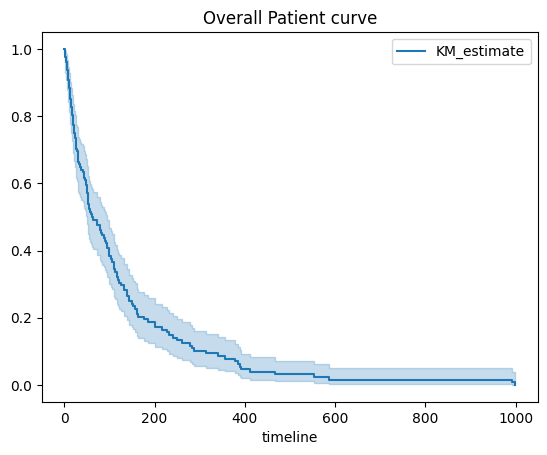

In [ ]:
kmf=KaplanMeierFitter()
#separate your event(y=1 or y=0)
df_event=df[df['Y']==1]

#for overall patient curve
kmf.fit(durations=df_event['TIME'],event_observed=df_event['Y'])
kmf.plot_survival_function()
plt.title('Overall Patient curve')
plt.show()

Now it compares survival curves between different treatment groups. It loops through unique treatment values, filters the data accordingly, fits a Kaplan-Meier curve for each group, and plots them to visually compare treatment effectiveness.

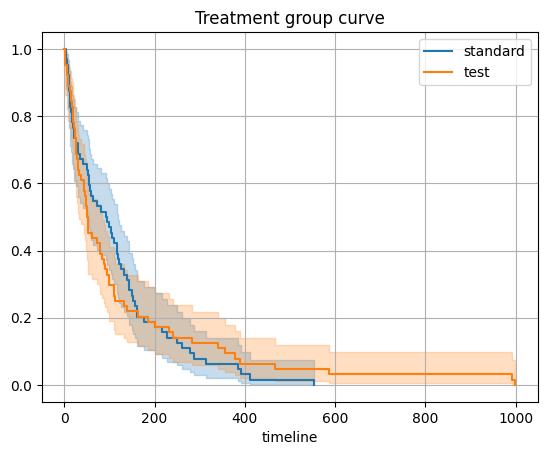

In [ ]:
#curve according to treatment group
for trt_group in df_event['trt'].unique():
  mask=df_event['trt']==trt_group
  kmf.fit(df_event[mask]['TIME'],df_event[mask]['Y'],label=trt_group)
  kmf.plot_survival_function()
plt.grid()
plt.title('Treatment group curve')
plt.show()

## Median Survival Time


---

 The median survival time shows how long it takes for half of the patients to experience the event, such as death. It is taken from the Kaplan-Meier survival curve and helps to understand how effective a treatment is. For example, if one group has a longer median survival time than another, it means that group stayed healthier for a longer time.


---



It calculates and prints the median survival time for each treatment group. It uses Kaplan-Meier estimation to fit each group’s survival function and accesses the median survival time attribute to report the result.

In [ ]:
for trt_group in df_event['trt'].unique():
  mask=df_event['trt']==trt_group
  kmf.fit(df_event[mask]['TIME'],df_event[mask]['Y'],label=str(trt_group)+'median='+str(np.median(df_event[mask]['TIME'])))
  print(f"Median survival time for {trt_group} is {np.median(df_event[mask]['TIME'])}")

Median survival time for standard is 93.5
Median survival time for test is 51.5


## Log-Rank Test


---

 The log-rank test is used to compare the survival times of two or more groups of patients, such as those receiving different treatments. It checks if there is a meaningful difference between the survival curves of the groups. If the result of the test shows a small p-value, it means there is a significant difference in how long the patients survive in each group, helping to decide which treatment works better.


---



In this a log-rank test use to compare the survival times of two treatment groups: "standard" and "test". It filters the dataset accordingly and uses the logrank_test() function to assess if the differences in survival times are statistically significant. The summary of test results is printed, which typically includes a p-value.

In [ ]:
from lifelines.statistics import logrank_test
group1=df_event[df_event['trt']=='standard']
group2=df_event[df_event['trt']=='test']
results=logrank_test(group1['TIME'],group2['TIME'],event_observed_A=group1['Y'],event_observed_B=group2['Y'])
print(results.summary)

   test_statistic        p  -log2(p)
0          0.0116  0.91423  0.129371


## Cox Proportional Hazards model


---

Cox Proportional Hazards Model, a commonly used method in survival analysis for assessing the effect of several variables at once on survival time.

---



It prepares the data for Cox regression analysis. It creates a copy of the filtered event data and encodes categorical variables (trt, celltype, priortherapy) into dummy variables using encoding, which is necessary for regression analysis.

In [ ]:
from lifelines import CoxPHFitter
#prepare wide-formate data: one row per subject
df_wide=df_event.copy()
#Encode categorical variables
df_wide=pd.get_dummies(df_wide,columns=['trt','celltype','priortherapy'],drop_first=True)

Now it fits the Cox Proportional Hazards model using the prepared dataset. The model is trained with TIME as the duration and Y as the event indicator. The model's summary is printed to show the hazard ratios and statistical significance of each variable. The plot() function visualizes the hazard ratios, where a value >1 indicates increased risk and <1 indicates reduced risk.

<lifelines.CoxPHFitter: fitted with 128 total observations, 0 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
      baseline estimation = breslow
   number of observations = 128
number of events observed = 128
   partial log-likelihood = -465.21
         time fit was run = 2025-06-05 10:09:01 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
ID                  0.00      1.00      0.01           -0.03            0.03                0.97                1.03
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.16      1.17      1.02           -1.84            2.16                0.16                8.63
celltype_large     -0.83      0.43      0.36           -1.53           -0.14                0.22                0.87
celltype_smallcell -0.12      0.88      0.38           -0.88            0.63                0.42                1.88
celltype_squamous  -0.97      0.38      0.66           -2.27            0.33                0.10                1.38
priortherapy_yes    0.18      1.20      0.24           -0.28            0.65                0.76                1.91

                    cmp to     z      p  -log2(p)
covariate                                        
ID                    0.00  0.20   0.84      0.25
karno                 0.00 -6.08 <0.005     29.60
diagtime              0.00 -0.47   0.63      0.66
age                   0.00 -1.54   0.12      3.02
trt_test              0.00  0.16   0.88      0.19
celltype_large        0.00 -2.34   0.02      5.71
celltype_smallcell    0.00 -0.32   0.75      0.42
celltype_squamous     0.00 -1.47   0.14      2.82
priortherapy_yes      0.00  0.79   0.43      1.21
---
Concordance = 0.74
Partial AIC = 948.43
log-likelihood ratio test = 62.38 on 9 df
-log2(p) of ll-ratio test = 31.00

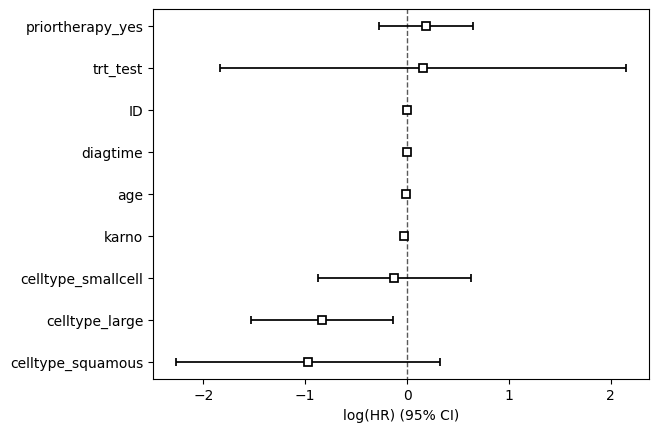

In [ ]:
cph=CoxPHFitter()
cph.fit(df_wide,duration_col='TIME',event_col='Y')
cph.print_summary()
cph.plot()
plt.show()
#if hazard score is >1 then higher risk and <1 less risk

##  Stratified Cox Model
The Stratified Cox Model is a special type of survival analysis used when we think different groups (like cancer cell types) may have different starting risk levels. It lets each group have its own base risk (called baseline hazard), but still checks how other factors (like treatment or prior therapy) affect survival in the same way across all groups. This method is helpful when the usual Cox model doesn’t work well because the risk patterns are too different between groups.

When different patients have different risk patterns (Stratified Cox Model)

In [ ]:
df_encoded = pd.get_dummies(df, columns=['trt', 'priortherapy'], drop_first=True)

# Fit Stratified Cox Model using 'celltype' as the strata
cph_strat = CoxPHFitter()
cph_strat.fit(df_encoded, duration_col='TIME', event_col='Y', strata=['celltype'])
cph_strat.print_summary()


<lifelines.CoxPHFitter: fitted with 274 total observations, 146 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
                   strata = celltype
      baseline estimation = breslow
   number of observations = 274
number of events observed = 128
   partial log-likelihood = -315.99
         time fit was run = 2025-06-05 10:09:01 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
ID                0.02      1.02      0.02           -0.01            0.05                0.99                1.05
karno            -0.04      0.96      0.01           -0.05           -0.03                0.95                0.97
diagtime         -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
age              -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
trt_test         -0.90      0.41      1.09           -3.03            1.24                0.05                3.44
priortherapy_yes  0.22      1.24      0.24           -0.25            0.69                0.78                1.99

                  cmp to     z      p  -log2(p)
covariate                                      
ID                  0.00  1.11   0.27      1.90
karno               0.00 -6.52 <0.005     33.73
diagtime            0.00 -0.60   0.55      0.86
age                 0.00 -1.41   0.16      2.65
trt_test            0.00 -0.82   0.41      1.29
priortherapy_yes    0.00  0.90   0.37      1.44
---
Concordance = 0.71
Partial AIC = 643.99
log-likelihood ratio test = 45.48 on 6 df
-log2(p) of ll-ratio test = 24.67

## Time varying survival analysis


---


Time-varying survival analysis is used when certain factors, like treatment or health conditions, can change over time and affect a patient’s survival. Instead of assuming these factors stay the same, this method takes into account their changes during the follow-up period. This helps give a more accurate understanding of how survival chances are affected as things change for each patient over time.



---



 It separates the data into start and event observations, renames columns to reflect time intervals (start, stop), and merges them using patient ID. Then it encodes categorical features and prints a preview of the key columns.

When patient condition changes over time (Time-Varying Covariate Model)

In [ ]:
#step 1:Separate rows by Y
df_start=df[df['Y']==0].copy() #start of observation/censoring
df_event=df[df['Y']==1].copy() #Death

#step 2:Merge on ID
#Bring over TIME as stop and Y as event
df_event=df_event.rename(columns={"TIME":"stop","Y":"event"})
df_start=df_start.rename(columns={"TIME":"start"})

df_timevarying=pd.merge(df_start,df_event[["ID","stop","event"]],on="ID")
df_timevarying=pd.get_dummies(df_timevarying,columns=['trt','celltype','priortherapy'],drop_first=True)

#final check
print(df_timevarying[["ID","start","stop","event"]].head())

   ID  start  stop  event
0   1      0    72      1
1   2      0   411      1
2   3      0   228      1
3   4      0   126      1
4   5      0   118      1


Before modeling, it checks for missing values in the dataset. It also ensures that the column Y is removed from the time-varying dataset to prevent redundancy or confusion during model fitting.

In [ ]:
#check there is null value
print(df_timevarying.isnull().sum())
#ensure y is not in the modeling data
if 'Y' in df_timevarying.columns:
   df_timevarying.drop(columns=['Y'],inplace=True)


ID                    0
start                 0
Y                     0
karno                 0
diagtime              0
age                   0
stop                  0
event                 0
trt_test              0
celltype_large        0
celltype_smallcell    0
celltype_squamous     0
priortherapy_yes      0
dtype: int64


## cox time-varying coefficient


---

Cox Time-Varying Coefficient Model allows the modeling of effects of covariates that may change during the observation period.



---



It fits a time-varying Cox model using CoxTimeVaryingFitter. It provides the patient ID, event occurrence, and the time interval (start, stop) for the analysis. The model summary and coefficient plots are then displayed to interpret the changing influence of covariates over time.

<lifelines.CoxTimeVaryingFitter: fitted with 128 periods, 128 subjects, 128 events>
         event col = 'event'
number of subjects = 128
 number of periods = 128
  number of events = 128
partial log-likelihood = -465.24
  time fit was run = 2025-06-05 10:09:01 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.36      1.44      0.21           -0.05            0.77                0.95                2.17
celltype_large     -0.80      0.45      0.30           -1.38           -0.21                0.25                0.81
celltype_smallcell -0.18      0.84      0.28           -0.72            0.36                0.49                1.44
celltype_squamous  -1.10      0.33      0.30           -1.68           -0.51                0.19                0.60
priortherapy_yes    0.18      1.19      0.23           -0.28            0.63                0.76                1.88

                    cmp to     z      p  -log2(p)
covariate                                        
karno                 0.00 -6.07 <0.005     29.52
diagtime              0.00 -0.45   0.65      0.61
age                   0.00 -1.53   0.12      3.00
trt_test              0.00  1.72   0.08      3.56
celltype_large        0.00 -2.65   0.01      6.95
celltype_smallcell    0.00 -0.65   0.52      0.96
celltype_squamous     0.00 -3.66 <0.005     11.94
priortherapy_yes      0.00  0.76   0.45      1.17
---
Partial AIC = 946.47
log-likelihood ratio test = 62.34 on 8 df
-log2(p) of ll-ratio test = 32.53

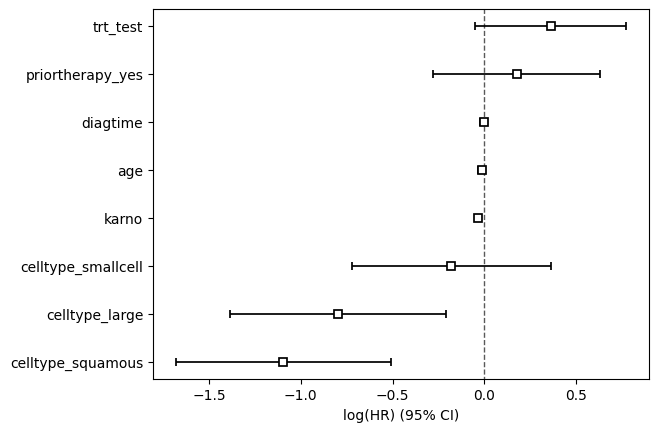

In [ ]:
#When patient condition changes over time
from lifelines import CoxTimeVaryingFitter
ctv=CoxTimeVaryingFitter()
ctv.fit(df_timevarying,id_col='ID',event_col='event',start_col='start',stop_col='stop')
ctv.print_summary()
ctv.plot()
plt.show()

## Kaplin-Meier Time varying


---

It creates and displays Kaplan-Meier survival curves to compare the survival probabilities of patients with different cell types over time. For each unique cell type in the dataset, it filters the data, fits the Kaplan-Meier estimator using the TIME (duration) and Y (event occurred or not) columns, and plots the survival function. The resulting graph shows how likely patients with each cell type are to survive as time increases, helping to visually compare which cell types are associated with better or worse survival outcomes.


---



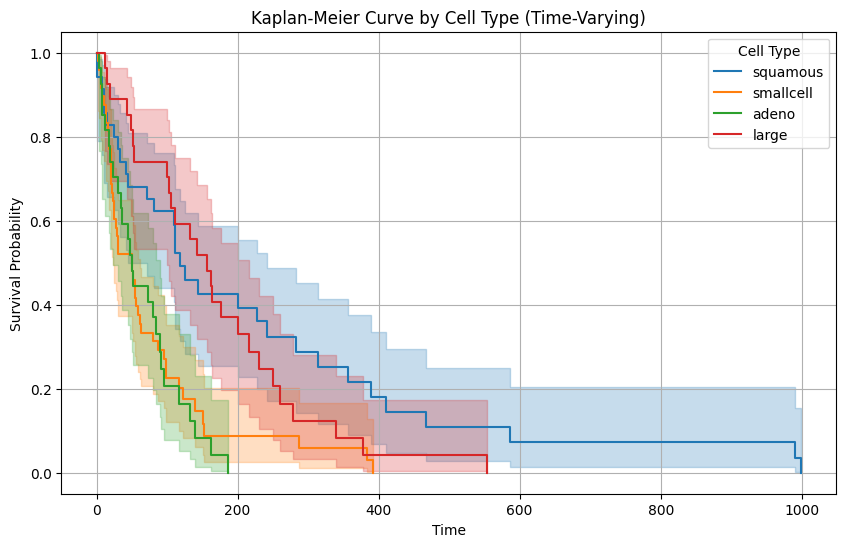

In [ ]:
plt.figure(figsize=(10, 6))
for cell in df['celltype'].unique():
    mask = df['celltype'] == cell
    kmf.fit(df[mask]['TIME'], event_observed=df[mask]['Y'], label=cell)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Curve by Cell Type (Time-Varying)')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend(title='Cell Type')
plt.grid(True)
plt.show()

## Log-Rank Test time varying


---

In this log-rank test compare the survival distributions between two groups of patients with different cell types — in this case, squamous and small cell lung cancer. The test checks if there is a statistically significant difference in survival time between the two groups, using their TIME and Y (event) values. The result helps determine whether one group tends to survive longer than the other, and whether the difference is likely due to chance or is statistically meaningful.

---



In [ ]:
group1 = df[df['celltype'] == 'squamous']
group2 = df[df['celltype'] == 'smallcell']

# Perform log-rank test between the two groups
results = logrank_test(group1['TIME'], group2['TIME'],
                       event_observed_A=group1['Y'], event_observed_B=group2['Y'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.57 <0.005     10.55

## What is a competing Risk?


---

competing risks refer to different possible reasons why a patient might not survive — for example, a patient may die from lung cancer (primary event) or from another unrelated cause like a heart attack (competing event). Once one event happens, the other events cannot happen. So, competing risks are alternative events that prevent the event of interest from occurring. Ignoring them can lead to misleading survival analysis results, especially when other risks are common.

---



###Fine-Gray Model


---

Fine-Gray model is used to analyze survival data when there are competing risks, meaning multiple possible reasons for death. For example, if the goal is to study death from lung cancer, deaths from other causes (like heart attacks) are competing events. The Fine-Gray model focuses on estimating the cumulative incidence — the probability over time that a patient experiences the specific event of interest, while properly accounting for the risk of other competing events.

---



When patients might experience different types of outcomes (Competing Risks Model)

In [ ]:
from lifelines import FineGrayFitter
df_competing = df.copy()
# Set event type based on Y and a condition for competing risk
df_competing['event_type'] = 0  # censored by default
df_competing.loc[df_competing['Y'] == 1, 'event_type'] = 1  # Event of interest
# Let's assume 'squamous' is a competing event type 2
df_competing.loc[(df_competing['Y'] == 1) & (df_competing['celltype'] == 'squamous'), 'event_type'] = 2

# Drop original 'Y' and one of the celltype dummies if using celltype in model
# dummy encoding for covariates
df_competing_encoded = pd.get_dummies(df_competing.drop(columns=['Y']), columns=['trt', 'celltype', 'priortherapy'], drop_first=True)

# Fit Fine-Gray model for event type 1 (the event of interest)
fgf = FineGrayFitter(event_of_interest=1)

# Fit the model. Use 'TIME' as duration, 'event_type' as observed event type
# Exclude the original 'celltype_squamous' dummy if 'event_type' is defined based on it and celltype
# Adjust the columns passed to fit if needed based on how event_type is defined
covariates = [col for col in df_competing_encoded.columns if col not in ['ID', 'TIME', 'event_type']]
fgf.fit(df_competing_encoded, duration_col='TIME', event_col='event_type', formula='+'.join(covariates))

fgf.print_summary()





## Conclusion

---

In this project, I explored different statistical methods to understand the survival patterns of lung cancer patients. I started by learning how to work with the time until events like death or recovery happen. Using Kaplan-Meier survival curves, I was able to visualize how long patients lived under different treatment types. This helped compare which treatment seemed more effective over time.

To see if those survival differences were real or just by chance, I used the Log-Rank Test. This confirmed that there were meaningful differences in survival between different groups, such as types of cancer cells.

Next, I used the Cox Proportional Hazards Model to study how different factors like treatment and patient condition affect survival. Then, I went further with the Time-Varying Covariate Model, which was helpful in tracking how changes in a patient’s condition over time could impact their survival.

To handle situations where different groups (like cell types) might naturally have different risks, I applied the Stratified Cox Model. This allowed me to adjust for those differences without treating them the same.

Finally, I explored more complex situations with the Competing Risks Model. This was important because not all patients died from lung cancer—some had other causes. Using the Fine-Gray model, I could focus on the real risk of dying from lung cancer while considering those other outcomes too.

##Final Decision
Treatment type, cancer cell type, and patient condition are significant determinants of survival, highlighting the importance of personalized treatment approaches to improve patient outcomes.
